In [ ]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np

dl = DataLoader("/home/panda/rf_data/")

picmus_names = [
    "contrast_speckle_expe_dataset_rf",
    "contrast_speckle_simu_dataset_rf",
    "resolution_distorsion_expe_dataset_rf",
    "resolution_distorsion_simu_dataset_rf",
    "carotid_cross_expe_dataset_rf",
    "carotid_long_expe_dataset_rf"
]

picmus_names = [ "contrast_speckle_expe_dataset_rf" ]
#picmus_names = [ "carotid_cross_expe_dataset_rf" ]


#nz = 1024
#nx = 512

nz = 2048
nx = 256

#nz = 1280
#nx = 720

device = "cuda"
dtype = torch.float32

In [2]:
from deep_bf.wrapper import BenchmarkWrapper
from torch.profiler import profile, ProfilerActivity, schedule

bf_names = [
    "DASGridSample",
    "DASManual",
    "FDMAS",
    "MVB"
]

bf_names = ["MVB"]
#bf_names = ["DASGridSample"]

output = {}
for name in picmus_names:
    print(name)
    pw = dl.get_defined_pwdata(name, "RF")
    angles_idx = np.arange(pw.n_angles)
    #angles_idx = np.array([0, 10, 32, 33, 60, 74])
    #angles_idx = np.array([32])

    f_num = 1.75
    window = "tukey25"

    with torch.profiler.profile(
        activities=[
            ProfilerActivity.CPU,
            ProfilerActivity.CUDA,
        ],
        record_shapes=True,
        profile_memory=True,
        with_stack=True,
        with_flops=False, 
    ) as prof:
        bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
        output[name] = bw.compute_reconstructions()
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=-1))


contrast_speckle_expe_dataset_rf
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                               aten::linalg_cholesky_ex         0.08%      13.717ms         0.32%      51.136ms     227.273us        3.056s        19.54%        4.394s      19.531ms           0 B        

In [3]:
from deep_bf.wrapper import BenchmarkWrapper
from torch.profiler import profile, ProfilerActivity, schedule

bf_names = [
    "DASGridSample",
    "DASManual",
    "FDMAS",
    "MVB"
]

#bf_names = ["MVB"]
bf_names = ["DASGridSample"]

output = {}
for name in picmus_names:
    print(name)
    pw = dl.get_defined_pwdata(name, "RF")
    angles_idx = np.arange(pw.n_angles)
    #angles_idx = np.array([0, 10, 32, 33, 60, 74])
    #angles_idx = np.array([32])

    f_num = 1.75
    window = "tukey25"

    
    bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
    output[name] = bw.compute_reconstructions()

contrast_speckle_expe_dataset_rf


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.09 GiB. GPU 0 has a total capacity of 23.54 GiB of which 1.45 GiB is free. Process 1328 has 70.78 MiB memory in use. Including non-PyTorch memory, this process has 20.62 GiB memory in use. Of the allocated memory 20.06 GiB is allocated by PyTorch, and 264.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

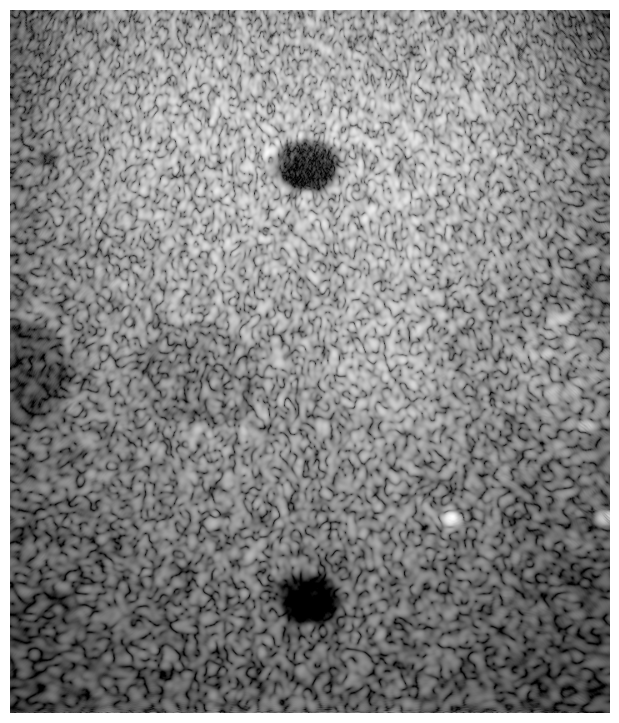

In [8]:
import matplotlib.pyplot as plt

picmus_idx = 0
bf_idx = 0
o = output[picmus_names[picmus_idx]][bf_names[bf_idx]]

vmin = -50
vmax = 0

fig = plt.figure(figsize=(6, 8), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = o.get_bmode(vmin=vmin, vmax=vmax)
extent = (o.xlims[0], o.xlims[-1], o.zlims[-1], o.zlims[0])


ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()